# Analyzing 911 reported incidents 2015 - 2020

All the data in this dataset is from "Montgomery County, Pennsylvania".

In [42]:
import numpy as np 
import pandas as pd
import seaborn as sb
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import rcParams
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import datetime as dt
import folium
from folium.plugins import MarkerCluster
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
plt.style.use('ggplot')
%matplotlib inline

data = pd.read_csv('911.csv')
data.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


In [18]:
data.describe()

,lat,lng,zip,e
count,663522.000000,663522.000000,583323.000000,663522.0
mean,40.158162,-75.300105,19236.055791,1.0
std,0.220641,1.672884,298.222637,0.0
min,0.000000,-119.698206,1104.000000,1.0
25%,40.100344,-75.392735,19038.000000,1.0
50%,40.143927,-75.305143,19401.000000,1.0
75%,40.229008,-75.211865,19446.000000,1.0
max,51.335390,87.854975,77316.000000,1.0


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663522 entries, 0 to 663521
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   lat        663522 non-null  float64
 1   lng        663522 non-null  float64
 2   desc       663522 non-null  object 
 3   zip        583323 non-null  float64
 4   title      663522 non-null  object 
 5   timeStamp  663522 non-null  object 
 6   twp        663229 non-null  object 
 7   addr       663522 non-null  object 
 8   e          663522 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 45.6+ MB


## Lets Do Some data Cleaning for accurate Data Analyzing

In [20]:
#Lets handle missing data

data.isnull().sum()

lat              0
lng              0
desc             0
zip          80199
title            0
timeStamp        0
twp            293
addr             0
e                0
dtype: int64

Lets leave zip for now we will only use it for the top 10 zip codes for most number of 911 calls.

In [22]:
data.dropna(subset=['twp'],inplace=True)

In [23]:
data.isnull().sum()

lat              0
lng              0
desc             0
zip          80030
title            0
timeStamp        0
twp              0
addr             0
e                0
dtype: int64

In [24]:
#lets convery timeStamp column to dataStamp and also separate each feature like Day,Month,Year,Month
data['timeStamp'] = pd.to_datetime(data['timeStamp'])
data['year'] = data['timeStamp'].dt.year
data['day'] = data['timeStamp'].dt.day
data['month'] = data['timeStamp'].dt.month
data['dayofweek'] = data['timeStamp'].dt.dayofweek
data['dayofyear'] = data['timeStamp'].dt.dayofyear
data['hour'] = data['timeStamp'].dt.hour

In [25]:
data.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e,year,day,month,dayofweek,dayofyear,hour
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1,2015,10,12,3,344,17
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1,2015,10,12,3,344,17
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1,2015,10,12,3,344,14
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1,2015,10,12,3,344,16
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1,2015,10,12,3,344,16


In [26]:
#Adding one column to our data : 'reason_cat' for the category of reason. This will enable us to better understand and visualize the dataset.
data['reason_cat'] = data['title'].apply(lambda x:x.split(':')[0])
data['reason_cat'].unique()

array(['EMS', 'Fire', 'Traffic'], dtype=object)

In [27]:
#lets create all reasons of call
data['title'] = data['title'].apply(lambda x:x.split(':')[1])
data['title'] = data['title'].apply(lambda x:x.split('-')[0]).apply(lambda x:x.strip())
data['title'].unique()

array(['BACK PAINS/INJURY', 'DIABETIC EMERGENCY', 'GAS',
       'CARDIAC EMERGENCY', 'DIZZINESS', 'HEAD INJURY', 'NAUSEA/VOMITING',
       'RESPIRATORY EMERGENCY', 'SYNCOPAL EPISODE', 'VEHICLE ACCIDENT',
       'DISABLED VEHICLE', 'APPLIANCE FIRE', 'GENERAL WEAKNESS',
       'CARBON MONOXIDE DETECTOR', 'UNKNOWN MEDICAL EMERGENCY',
       'UNRESPONSIVE SUBJECT', 'ALTERED MENTAL STATUS', 'FIRE ALARM',
       'CVA/STROKE', 'ROAD OBSTRUCTION', 'SUBJECT IN PAIN',
       'HEMORRHAGING', 'FALL VICTIM', 'ASSAULT VICTIM', 'SEIZURES',
       'MEDICAL ALERT ALARM', 'ABDOMINAL PAINS', 'PUMP DETAIL',
       'FIRE INVESTIGATION', 'OVERDOSE', 'MATERNITY',
       'UNCONSCIOUS SUBJECT', 'CHOKING', 'LACERATIONS',
       'TRASH/DUMPSTER FIRE', 'UNKNOWN TYPE FIRE', 'BUILDING FIRE',
       'ELECTRICAL FIRE OUTSIDE', 'DEBRIS/FLUIDS ON HIGHWAY', 'FEVER',
       'ALLERGIC REACTION', 'VEHICLE LEAKING FUEL', 'FRACTURE',
       'BURN VICTIM', 'RESCUE', 'WOODS/FIELD FIRE',
       'FIRE SPECIAL SERVICE', 'VEHICLE 

In [28]:
# how many total reasons are there?
data['title'].nunique()

85

# Lets Visualize

In [30]:
reason = pd.DataFrame({'reason':['EMS', 'Traffic', 'Fire'], 'count':[3265850, 227045, 98797]})
reason.style.background_gradient(cmap='Reds', subset=['count'])

,reason,count
0,EMS,3265850
1,Traffic,227045
2,Fire,98797


In [35]:
# Bar Chart
fig1 = px.bar(reason, reason['reason'], reason['count'], color_discrete_sequence=[px.colors.qualitative.Pastel], text=reason['count'])

fig1.update_layout(title={
                  'text': "Category of Reasons for 911 Calls",
                  'y':0.98,
                  'x':0.5,
                  'xanchor': 'center',
                  'yanchor': 'top'},
                  xaxis_title='Reason Category',
                  yaxis_title='Count',
                  showlegend=False,
                  template='ggplot2')



# Pie Chart
fig2 = px.pie(reason, reason['reason'], reason['count'], 
              color_discrete_sequence=px.colors.qualitative.Pastel, hole=0.5)

fig2.update_layout(title={
                  'text': "Category of Reasons for 911 Calls (Pie Chart)",
                  'y':0.98,
                  'x':0.5,
                  'xanchor': 'center',
                  'yanchor': 'top'},
                   height=600,
                  template='plotly_white')

fig2.update_traces(textposition='inside', textinfo='percent+label', pull=[0.2, 0, 0])

fig2.data[0].marker.line.width = 2
fig2.data[0].marker.line.color = "black"



fig1.show()
fig2.show()

<ul><li>EMS (Emergency Medical Services) calls are the most frequent.</li>
    <li>Traffic calls are less frequent and Fire calls being the least frequent.</li>
    </ul>

In [37]:
#Top 10 reasons for 911 calls in "Montgomery County, Pennsylvania".

data['title'].value_counts()\
             .head(10)\
             .to_frame(name='count')\
             .reset_index()\
             .style.background_gradient(cmap='Reds', subset=['count'])

,index,count
0,VEHICLE ACCIDENT,184661
1,DISABLED VEHICLE,47915
2,FIRE ALARM,38444
3,FALL VICTIM,34675
4,RESPIRATORY EMERGENCY,34241
5,CARDIAC EMERGENCY,32329
6,ROAD OBSTRUCTION,23237
7,SUBJECT IN PAIN,19644
8,HEAD INJURY,18301
9,GENERAL WEAKNESS,11866


In [38]:
data['title'].value_counts().head(10).iplot(kind='bar', 
                 color='red',
                 gridcolor='white',
                 linecolor='black',
                 theme='pearl',
                 title='Township',
                 yTitle='Number of 911 Calss',
                 bargap=0.4,
                 xTitle='Day of Week'
                 )

C:\Users\Jonty\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



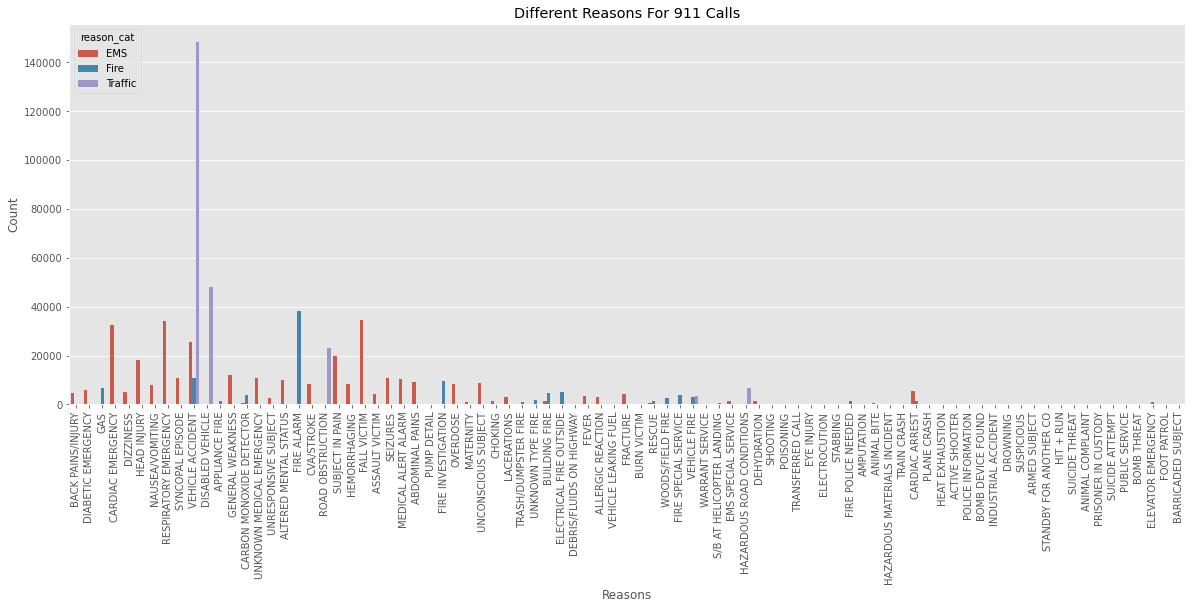

In [39]:
plt.subplots(figsize=(20, 7))

ax = sb.countplot(data['title'], hue=data['reason_cat'], data=data)
ax.set(xlabel='Reasons', ylabel='Count')
plt.title('Different Reasons For 911 Calls')

plt.xticks(rotation=90)

plt.show()

In [40]:
top_10_reasons = data['title'].value_counts().to_frame(name='count').head(10).sort_values(by='count')
fig = px.bar(top_10_reasons, color_discrete_sequence=[px.colors.qualitative.Pastel], orientation='h', text=top_10_reasons['count'].sort_values(ascending=True))

fig.update_layout(title={
                  'text': "Top 10 Reasons for 911 Calls",
                  'y':0.98,
                  'x':0.5,
                  'xanchor': 'center',
                  'yanchor': 'top'},
                  xaxis_title='Reasons',
                  yaxis_title='Count',
                  showlegend=False,
                  template='plotly_white')

fig.show()

<ul><li>Approximately 28% of all calls are for vehicle accident.
</li>
<li>Followed by disabled vehicle calls which constitutes nearly 7% of all calls.
</li></ul>

C:\Users\Jonty\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



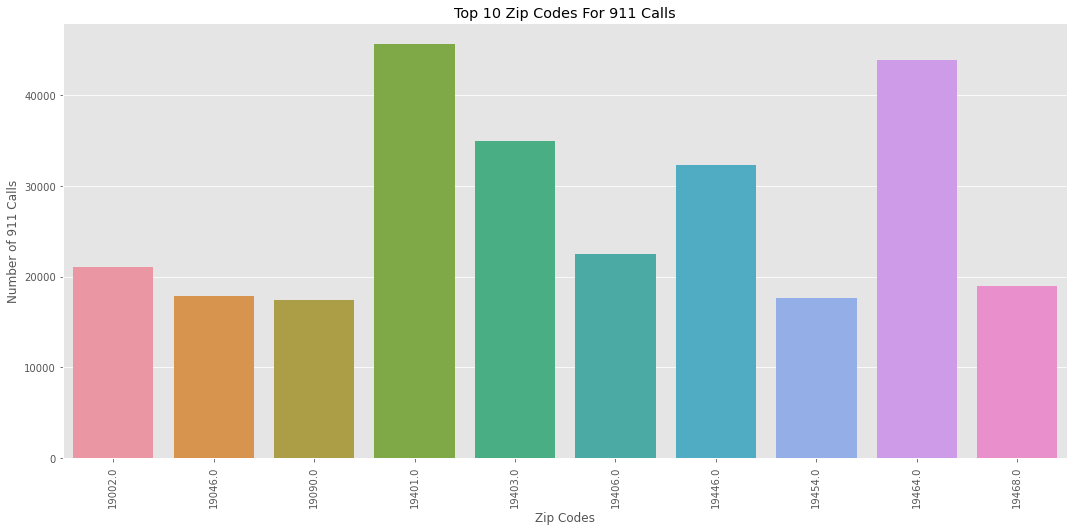

In [43]:
top_10_zip = data['zip'].value_counts().to_frame(name='count').head(10).sort_values(by='count')

plt.subplots(figsize=(18, 8))
ax = sb.barplot(top_10_zip.index, top_10_zip['count'])
plt.xticks(rotation=90)
ax.set(xlabel='Zip Codes', ylabel='Number of 911 Calls')
plt.title('Top 10 Zip Codes For 911 Calls')

plt.show()

In [44]:
#911 calls based on different Township

data['twp'].value_counts()\
           .head(20)\
           .to_frame(name='count')\
           .reset_index()\
           .style.background_gradient(cmap='Reds', subset=['count'])

,index,count
0,LOWER MERION,55490
1,ABINGTON,39947
2,NORRISTOWN,37633
3,UPPER MERION,36010
4,CHELTENHAM,30574
5,POTTSTOWN,27387
6,UPPER MORELAND,22932
7,LOWER PROVIDENCE,22476
8,PLYMOUTH,20116
9,UPPER DUBLIN,18862


In [45]:
top_10_twp = data['twp'].value_counts().to_frame(name='count').head(10).sort_values(by='count') 

top_10_twp.iplot(kind='bar', 
                 color='red',
                 gridcolor='white',
                 linecolor='black',
                 theme='pearl',
                 title='Township',
                 yTitle='Number of 911 Calss',
                 bargap=0.3,
                 xTitle='Day of Week'
                 )

In [48]:
#folium map (location)

map_plot_20 = data[['lat', 'lng', 'twp']].groupby('twp').mean().reset_index()
map_plot_20.head(15).style.background_gradient(cmap='Reds', subset=['lat'])\
                    .background_gradient(cmap='Greens', subset=['lng'])


,twp,lat,lng
0,ABINGTON,40.113117,-75.121183
1,AMBLER,40.157625,-75.221750
2,BERKS COUNTY,40.286974,-75.584377
3,BRIDGEPORT,40.103989,-75.343111
4,BRYN ATHYN,40.136988,-75.063574
5,BUCKS COUNTY,40.259311,-75.271204
6,CHELTENHAM,40.078186,-75.133883
7,CHESTER COUNTY,40.213753,-75.532586
8,COLLEGEVILLE,40.186532,-75.456492
9,CONSHOHOCKEN,40.076381,-75.303204


In [52]:
map_data = folium.Map(location=(40.2547, -75.3405), zoom_start = 11, width='70%', max_zoom=11, min_zoom=11)

for lat, lng, twp in zip(map_plot_20.lat, map_plot_20.lng, map_plot_20.twp):
    folium.Marker(
    radius=1,
    location=[lat, lng],
    color='crimson',
    popup=twp,
    icon=folium.Icon(color='red'),
    ).add_to(map_data)




display(map_data)

In [54]:
data.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


In [62]:
data=df
df.head()

,lat,lng,desc,zip,title,twp,addr,e,hour,day,month,year,reason
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,NEW HANOVER,REINDEER CT & DEAD END,1,17,Thursday,12,2015,EMS
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1,17,Thursday,12,2015,EMS
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,NORRISTOWN,HAWS AVE,1,14,Thursday,12,2015,Fire
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,NORRISTOWN,AIRY ST & SWEDE ST,1,16,Thursday,12,2015,EMS
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1,16,Thursday,12,2015,EMS
